In [1]:
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from sympy import *
from IPython.display import display, Math
import numpy as np
init_printing(use_unicode=True)


In [2]:
from sympy import solve

x, y, sigma, mu, delta, alpha, beta, ro, eta, b, lambd = symbols(
    'x y σ μ δ α β ρ η b λ')

sigma_c = 0.1181
ro_c = 1.131
eta_c = 20.19
alpha_c = 1.636
beta_c = 0.002
delta_c = 0.3743
mu_c = 0.005
b_c = 0

dxdt = sigma + ro*x*y/(eta + y) - mu*x*y - delta*x
dydt = alpha*y*(1-beta*y)-x*y-(b*y)/(1+y)

concrete_params = {ro: ro_c, sigma: sigma_c, eta: eta_c, b: b_c,
                   alpha: alpha_c, beta: beta_c, mu: mu_c, delta: delta_c}
muless_params = dict(concrete_params)
del muless_params[mu]

bless_params = dict(concrete_params)
del bless_params[b]


In [3]:
display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))
display(Math('\dfrac{dy}{dt} = ' + latex(dydt)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Точки равновесия

### 1

In [4]:
display(Math('x = ' + latex(sigma/delta)))
display(Math('y = 0'))  # Решение не зависит от μ


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# Остаьные равновесия аналитически не найти. Полином 5 степени.


In [6]:
def get_solutions(params):
    return solve([dxdt.subs(params), dydt.subs(params)], x, y)


In [7]:
def display_solutions(sols):
    for s in sols:
        display(s)


In [8]:
def display_sol_list(sol_list):
    for cur_mu, sols in sol_list:
        print(f"mu = {cur_mu}")
        display_solutions(sols)
        display("*"*20)


In [9]:
from typing import Tuple


def sol_is_almost_real(sol):
    x, y = sol
    return abs(im(x)) < 1e-10 and abs(im(y)) < 1e-10


def cast_to_real(sol):
    x, y = sol
    return re(x), re(y)


In [10]:
dfdx = diff(dxdt, x)
dfdy = diff(dxdt, y)
dgdx = diff(dydt, x)
dgdy = diff(dydt, y)


In [11]:
display(Math('\dfrac{df}{dx} = ' + latex(dfdx)))
display(Math('\dfrac{df}{dy} = ' + latex(dfdy)))
display(Math('\dfrac{dg}{dx} = ' + latex(dgdx)))
display(Math('\dfrac{dg}{dy} = ' + latex(dfdy)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
def get_eigen_values(x_eq, y_eq, params):
    a11 = dfdx.evalf(subs=params | {x: x_eq, y: y_eq})
    a12 = dfdy.evalf(subs=params | {x: x_eq, y: y_eq})
    a21 = dgdx.evalf(subs=params | {x: x_eq, y: y_eq})
    a22 = dgdy.evalf(subs=params | {x: x_eq, y: y_eq})
    jacob_matrix = Matrix([[a11, a12], [a21, a22]])
    j = jacob_matrix - np.eye(2) * lambd
    lam1, lam2 = solve(j.det(), lambd)
    return lam1, lam2


In [13]:
def get_line_mode(stable):
    return {} if stable else {"dash": "dot"}


In [14]:
# for s in get_solutions():
#     display(s)


#### Бифуркационная диаграмма

In [15]:
# mus = np.linspace(0.002, 0.022, 50)

mus = np.concatenate([
    np.linspace(0.0020, 0.0026, 50, endpoint=False),
    np.linspace(0.0026, 0.00265, 50, endpoint=False),
    np.linspace(0.00265, 0.0040, 50, endpoint=False),
    np.linspace(0.0040, 0.0130, 50, endpoint=False),
    np.linspace(0.0131, 0.0133, 50, endpoint=False),
    np.linspace(0.0130, 0.0135, 50, endpoint=False),
    np.linspace(0.0135, 0.0220, 50, endpoint=False)
])


In [16]:
xs = []
ys = []
mul = []
solutions_by_mu = {}
for cur_mu in tqdm(mus):
    solutions = get_solutions(muless_params | {mu: cur_mu})
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    solutions_by_mu[cur_mu] = solutions


  1%|▎                                          | 3/350 [00:04<09:15,  1.60s/it]

KeyboardInterrupt



In [173]:
# y_im_parts = []
# x_im_parts = []
# mus_for_im=[]
# for cur_mu, sols in list(solutions_by_mu.items()):
#     for cur_x,cur_y in sols:
#         x_im_parts.append(float(cur_x))
#         y_im_parts.append(float(cur_y))
#         mus_for_im.append(cur_mu)

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=mus_for_im, y=x_im_parts, mode='markers', name = "x_im_parts"))
# fig.add_trace(go.Scatter(x=mus_for_im, y=y_im_parts, mode='markers', name = "y_im_parts"))
# fig.update_layout(title="Imaginary parts of X and Y")
# fig.update_layout(xaxis={"title": "mu"})


На отрезке [0.005, 0.015] мнимая часть близка к нулю

In [174]:
mu_min = 0.002
mu_max = 0.017
filtered_solutions_by_mu = {
    mu: solutions_by_mu[mu] for mu in solutions_by_mu if mu_min < mu < mu_max}
# filtered_solutions_by_mu


In [178]:
# display_sol_list(list(filtered_solutions_by_mu.items())[:2])


In [191]:
xs = []
ys = []
mus_bif = []
df = pd.DataFrame(columns=['mu', 'x', 'y', 'stable'])
for cur_mu, sols in tqdm(list(filtered_solutions_by_mu.items())):
    for cur_x, cur_y in sols:
        lam1, lam2 = get_eigen_values(float(cur_x), float(
            cur_y), muless_params | {mu: cur_mu})
        stable = re(lam1) < 0 and re(lam2) < 0
        df.loc[len(df)] = [cur_mu, float(cur_x), float(cur_y), stable]


df.stable = df.stable.astype(bool)
df = df[df.y != 0]


# fig.add_trace(go.Scatter(x=stables.mu, y=stables.y, mode='markers', name = "y"))


100%|█████████████████████████████████████████| 313/313 [01:51<00:00,  2.81it/s]


In [192]:
df.y = df.y.astype('float')
df.stable = df.stable.astype(bool)

df.sort_values('y', inplace=True)
stables = df[df.stable]
dormants = df[df.stable & (df.y < 200)]
actives = df[df.stable & (df.y > 200)]
unstables = df[~df.stable]


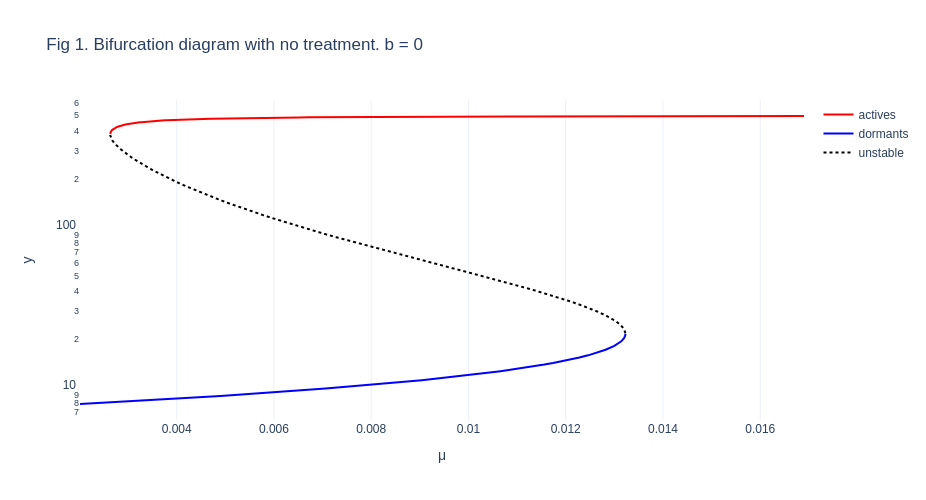

In [193]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=actives.mu, y=actives.y, mode='lines', name="actives",
                         line={"color": "red"} | get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=dormants.mu, y=dormants.y, mode='lines', name="dormants",
                         line={"color": "blue"} | get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=unstables.mu, y=unstables.y, mode='lines', name="unstable",
                         line={"color": "black"} | get_line_mode(stable=False)))
# fig.add_trace(go.Scatter(x=df.mu, y=df.y, mode='markers', name = "y"))
fig.update_layout(title="Fig 1. Bifurcation diagram with no treatment. b = 0")
fig.update_layout(xaxis={"title": "μ"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=600,
                  height=500)
fig.update_yaxes(type="log")
# fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)


## 𝜇 = 0.014. Monostable active. b is variable

In [16]:
mu_c = 0.014
bless_params[mu] = mu_c


In [17]:
def get_n_solutions_by_b(params, y_starts):
    res = set()
    for y_start in y_starts:
        try:
            res.add(ImmutableMatrix(
                nsolve([dxdt.subs(params), dydt.subs(params)], (x, y), (0, y_start))))
        # Could not find root within given tolerance. (1.56236416469305495856 > 2.16840434497100886801e-19)
        except ValueError:
            # Try another starting point or tweak arguments.
            pass
    return res


In [50]:
solutions_by_b = {}
bs_full_range = np.concatenate([
    np.linspace(0.0, 200, 500, endpoint=False),
    np.linspace(194, 195, 50, endpoint=False),
    np.linspace(10, 25, 100, endpoint=False),
])
bs_smalls = np.concatenate([
    np.linspace(0.0, 10, 100, endpoint=False),
    np.linspace(8.2, 8.4, 100, endpoint=False),
    np.linspace(8.334, 8.336, 10, endpoint=False)
])
for bs_set, y_starts in zip([bs_full_range, bs_smalls],
                            [np.linspace(0, 600, 6), np.linspace(0, 30, 6)]):
    for curb in tqdm(bs_set):
        solutions = get_n_solutions_by_b(bless_params | {b: curb}, y_starts)
        solutions = [cast_to_real(s)
                     for s in solutions if sol_is_almost_real(s)]
        solutions_by_b[curb] = solutions


100%|█████████████████████████████████████████| 210/210 [00:38<00:00,  5.49it/s]


In [136]:
bif_solutions_by_b = dict(solutions_by_b)


In [51]:
df = pd.DataFrame({'b': pd.Series(dtype='float'),
                   'x': pd.Series(dtype='float'),
                   'y': pd.Series(dtype='float'),
                   'stable': pd.Series(dtype='bool')})
for curb, sols in tqdm(solutions_by_b.items()):
    for sol in sols:
        cur_x, cur_y = sol
        lam1, lam2 = get_eigen_values(
            float(cur_x), float(cur_y), bless_params | {b: curb})
        stable = re(lam1) < 0 and re(lam2) < 0
        df.loc[len(df)] = [curb, float(cur_x), float(cur_y), stable]

df.stable = df.stable.astype(bool)
orig = df.copy()


100%|█████████████████████████████████████████| 824/824 [04:00<00:00,  3.42it/s]


In [101]:
df.b = df.b.astype(float)


In [102]:
# df = df[(df.y>=0) & (df.y.abs()>1e-10)]
df = df[(df.y >= 0)]
df.sort_values('y', inplace=True)


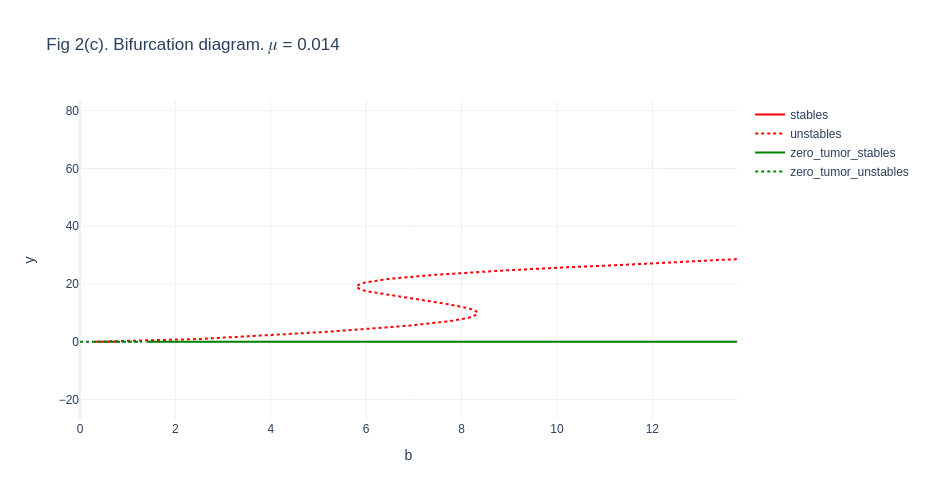

In [103]:
fig = go.Figure()
stables = df[df.stable & (df.y != 0)]
unstables = df[~df.stable & (df.y != 0)]
zero_tumor_stables = df[df.stable & (df.y == 0)]
zero_tumor_unstables = df[~df.stable & (df.y == 0)]

fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines', name="stables",
              line={"color": "red"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines', name="unstables",
                         line={"color": "red"} | get_line_mode(stable=False)))
fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name="zero_tumor_stables",
                         line={"color": "green"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name="zero_tumor_unstables",
                         line={"color": "green"} | get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=700,
                  height=500)


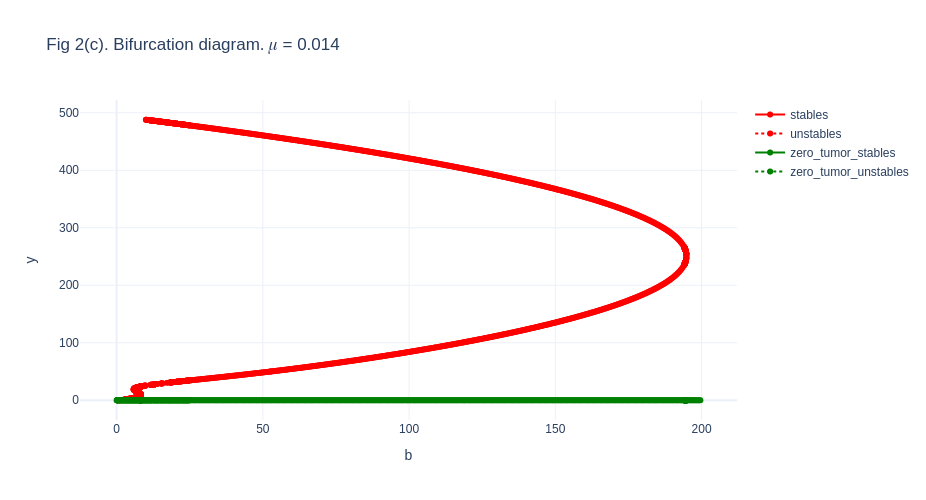

In [104]:
fig = go.Figure()
stables = df[df.stable & (df.y != 0)]
unstables = df[~df.stable & (df.y != 0)]
zero_tumor_stables = df[df.stable & (df.y == 0)]
zero_tumor_unstables = df[~df.stable & (df.y == 0)]

fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines+markers', name="stables",
              line={"color": "red"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines+markers', name="unstables",
                         line={"color": "red"} | get_line_mode(stable=False)))
fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines+markers', name="zero_tumor_stables",
                         line={"color": "green"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines+markers', name="zero_tumor_unstables",
                         line={"color": "green"} | get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=700,
                  height=500)


In [55]:
# Note: b в районе 10 - 20 - решения не находятся


In [105]:
dfsmall = df[df.b.isin(bs_smalls)]


In [123]:
b1 = 5.8
b2 = 8.3356


In [124]:
lower_flexure = dfsmall[(dfsmall.y > 5) & (dfsmall.y < 17)]
upper_flexure = dfsmall[(dfsmall.y > 17) & (dfsmall.y < 24)]
b2_exp = lower_flexure.b.max()
b1_exp = upper_flexure.b.min()
lower_flexure_y = dfsmall[(dfsmall.b == b2_exp) & (
    dfsmall.y < 10.5) & (dfsmall.y > 9)]
b1_exp, b2_exp


In [125]:
y_low_thrsh = lower_flexure_y.y.mean()
y_low_thrsh


In [131]:
pink = dfsmall[(dfsmall.b <= b2) & (dfsmall.y <= y_low_thrsh)
               & ~dfsmall.stable & (dfsmall.y > 0)]
blue = dfsmall[(dfsmall.b >= b1) & (dfsmall.b <= b2) & (
    y_low_thrsh < dfsmall.y) & (dfsmall.y < 19) & ~dfsmall.stable]
red = dfsmall[(dfsmall.b > b1) & (dfsmall.y > 18.8) & ~dfsmall.stable]

zero_tumor_stables = dfsmall[dfsmall.stable & (dfsmall.y == 0)]
zero_tumor_unstables = dfsmall[~dfsmall.stable & (dfsmall.y == 0)]


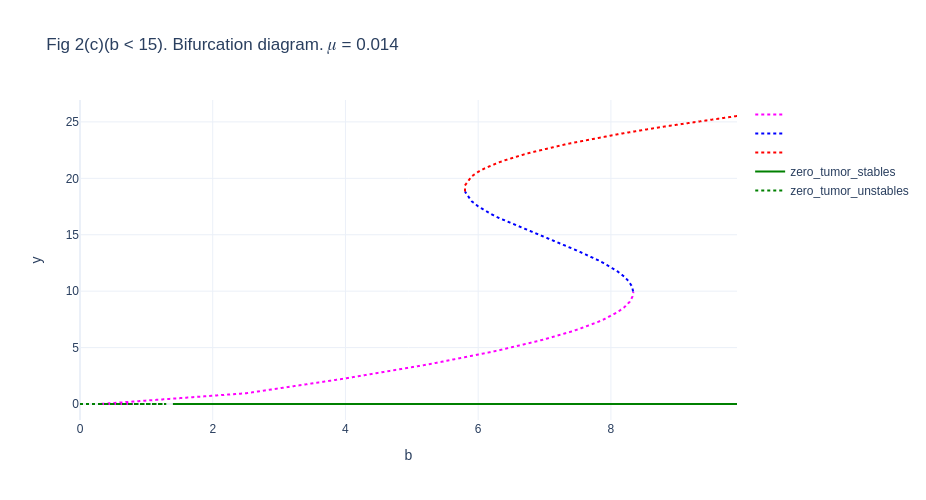

In [132]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=pink.b, y=pink.y, mode='lines', name="",
              line={"color": "magenta"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=blue.b, y=blue.y, mode='lines', name="",
              line={"color": "blue"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=red.b, y=red.y, mode='lines', name="",
              line={"color": "red"} | get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name="zero_tumor_stables",
                         line={"color": "green"} | get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name="zero_tumor_unstables",
                         line={"color": "green"} | get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c)(b < 15). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white", autosize=False,
                  width=700,
                  height=500)


In [134]:
df[df.b == 1]


,b,x,y,stable
1916,1.0,0.315522,0.0,False


In [ ]:
for bs_set, y_starts in zip([bs_full_range, bs_smalls],
                            [np.linspace(0, 600, 6), np.linspace(0, 30, 6)]):


In [63]:
def get_n_solutions_by_bxy(params, starts):
    res = set()
    for x_start, y_start in tqdm(starts):
        try:
            res.add(ImmutableMatrix(
                nsolve([dxdt.subs(params), dydt.subs(params)], (x, y), (x_start, y_start))))
        # Could not find root within given tolerance. (1.56236416469305495856 > 2.16840434497100886801e-19)
        except ValueError:
            # Try another starting point or tweak arguments.
            pass
    return res


In [64]:
b_c = 1


In [65]:
from itertools import product


In [68]:
bs_set = [b_c]
solutions_by_b = {}
starts = list(product(np.linspace(0, 1, 10), np.linspace(256, 1400, 10)))
solutions = get_n_solutions_by_bxy(bless_params | {b: curb}, starts)
solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 60.05it/s]


In [70]:
sorted(solutions)


### Фазовые портреты. b = 1, 𝜇 = 0.014

In [20]:
def f(x_c, y_c, params, reverse=False):  # dx/dt
    return (-1 if reverse else 1) * dxdt.evalf(subs=(params | {x: x_c, y: y_c}))


def g(x_c, y_c, params, reverse=False):  # dy/dt
    return (-1 if reverse else 1) * dydt.evalf(subs=(params | {x: x_c, y: y_c}))


def get_next(x, y, h, params, reverse=False):
    k1 = h * f(x, y, params, reverse=reverse)
    l1 = h * g(x, y, params, reverse=reverse)
    k2 = h * f(x + k1 / 2, y + l1 / 2, params, reverse=reverse)
    l2 = h * g(x + k1 / 2, y + l1 / 2,  params, reverse=reverse)
    k3 = h * f(x + k2 / 2, y + l2 / 2,  params, reverse=reverse)
    l3 = h * g(x + k2 / 2, y + l2 / 2,  params, reverse=reverse)
    k4 = h * f(x + k3, y + l3, params, reverse=reverse)
    l4 = h * g(x + k3, y + l3,  params, reverse=reverse)
    return (x + (k1 + 2 * k2 + 2 * k3 + k4) / 6,
            y + (l1 + 2 * l2 + 2 * l3 + l4) / 6)


In [21]:
get_next(3, 1, 0.001, bless_params | {b: b_c})


In [47]:
H = 0.01 * 5


In [71]:
starts = list(product([4], np.linspace(0, 1400, 6)))
paths = pd.DataFrame(columns=['no', 'step', 'x', 'y'])
for start_no, (x_c, y_c) in tqdm(list(enumerate(starts))):
    for step in range(500):
        paths.loc[len(paths)] = [start_no, step, x_c, y_c]
        x_c, y_c = get_next(x_c, y_c, H, bless_params | {b: b_c})
paths = paths.astype(float)


100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.95s/it]


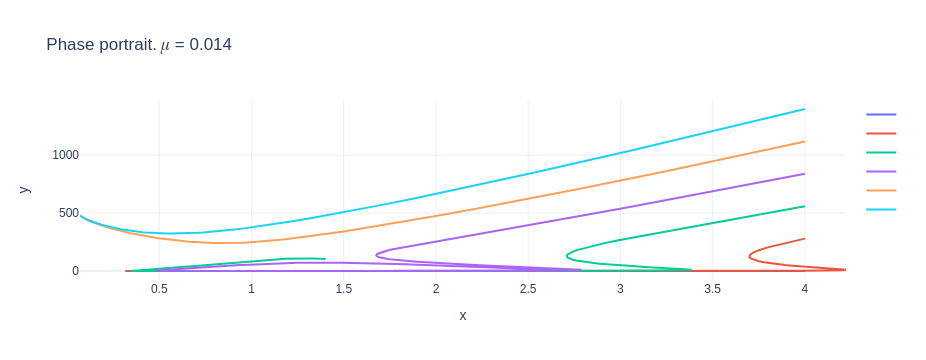

In [74]:
fig = go.Figure()
for path_no, path in paths.groupby("no"):
    fig.add_trace(go.Scatter(x=path.x, y=path.y, mode='lines', name="",
                             #                 marker=dict(
                             #     symbol="arrow",
                             #     size=6,
                             #     # color='green',
                             #     angleref="previous",
                             # )
                             ))

fig.update_layout(title="Phase portrait. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "x"}, yaxis={
                  "title": "y"}, template="plotly_white")
